In [7]:
import pandas as pd
from collections import Counter

In [8]:
import os
import random
import numpy as np
import pickle
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def normalizeTargets(i,file):
    ratefile =  os.path.join(file,file+"_rate.npy")
    
    nTargets_1 =np.load(ratefile)
    
    ratefile_train =  ratefile
    #os.path.join('train','train'+"_rate.npy")
    #ratefile_train =  os.path.join(file,file+"_rate.npy")
    
    nTa =np.load(ratefile_train)
    

    
    mean = np.mean(nTa,axis=0)
    std = np.std(nTa,axis=0)
    
    norm = 'zscore'

    if(norm == 'zscore'):
        nTargets =nTargets_1- mean
        nTargets = np.divide(nTargets,std,out=np.zeros_like(nTargets),where=std!=0)
        
    else:
        nTargets = -np.log(nTargets_1)

    return nTargets_1[i],nTargets[i],nTargets_1[i]*10e7

In [10]:
def de_normalizeTargets(error,file='train'):
    ratefile =  os.path.join(file,file+"_rate.npy")

    nTargets_1 =np.load(ratefile)

    ratefile_train =  ratefile
    
    #ratefile_train =  os.path.join(file,file+"_rate.npy")
    
    nTa =np.load(ratefile_train)
    

    
    mean = np.mean(nTa,axis=0)
    
    std = np.std(nTa,axis=0)
  

    erro = np.dot(error,std)+mean
   
   
    '''
    erro = np.exp(-error)
    '''
    return erro

In [11]:
def SNP_WINDOW(w,i,file):
 
    respectiveNormalizedTargets,respectiveNormalizedTargets_z,respectiveNormalizedTargets_scaled = normalizeTargets(i,file)
    targets= np.array(respectiveNormalizedTargets)
    z_target= np.array(respectiveNormalizedTargets_z)
    scaled_target = np.array(respectiveNormalizedTargets_scaled)
    
    lis=[]

    for i in w:
        co = dict(Counter(i))
        if len(co.keys())==2:
            lis.append(co[min(co,key=co.get)]/len(i))
    bins = np.linspace(0, 1, 20)

    bin_means,bins = np.histogram(lis, bins, normed=True, density=True)
    bins= bins[1:]
    bin_means= bin_means/bin_means.sum()
    
    #plt.bar(range(19), bin_means)
    #plt.show()


    
    

    return np.array(bins),targets,z_target,scaled_target,bin_means[:10]

In [12]:
def break_window(ha,po,ra,winsize):
    print(len(ha))
    bins = np.linspace(0, len(ha),winsize)

    bin_means,bins = np.histogram(ha, bins)
    print(bin_means)

In [13]:
def __data_generation1(batchTreeIndices,file):

        haps = []
        pos = []
        rate =[]
        for treeIndex in batchTreeIndices:
            Hfilepath = os.path.join(file,str(treeIndex) + "_haps.npy")
            #Pfilepath = os.path.join(file, str(treeIndex) +"_pos.npy")
            H = np.load(Hfilepath)
            #P = np.load(Pfilepath)

            haps.append(H)
            #pos.append(P)

        return haps#,pos


            
def __getitem__1(idx,val):
    X= __data_generation1([idx],val)
    return X#,x1

In [14]:
def logit_(val):
    ret_val=[]
    for i in range(len(val)):
           ret_val.append(np.log(val[i]))
            
    return ret_val
        

In [15]:
lis_train_150k=[]
train_target_un_150k=[]
train_target_z_150k=[]
train_target_scaled_150k=[]
for i in range(6000):
    x= __getitem__1(i,'train_150k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_150k')

    lis_train_150k.append(vale1)
        
    train_target_un_150k.append(targets)
    train_target_z_150k.append(z_target)
    train_target_scaled_150k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)


In [16]:
lis_train_100k=[]
train_target_un_100k=[]
train_target_z_100k=[]
train_target_scaled_100k=[]
for i in range(6000):
    x= __getitem__1(i,'train_100k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_100k')

    lis_train_100k.append(vale1)
        
    train_target_un_100k.append(targets)
    train_target_z_100k.append(z_target)
    train_target_scaled_100k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)


In [17]:
lis_train_50k=[]
train_target_un_50k=[]
train_target_z_50k=[]
train_target_scaled_50k=[]
for i in range(6000):
    x= __getitem__1(i,'train_50k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_50k')

    lis_train_50k.append(vale1)
        
    train_target_un_50k.append(targets)
    train_target_z_50k.append(z_target)
    train_target_scaled_50k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)


In [18]:
lis_train_10k=[]
train_target_un_10k=[]
train_target_z_10k=[]
train_target_scaled_10k=[]
for i in range(6000):
    x= __getitem__1(i,'train_10k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_10k')

    lis_train_10k.append(vale1)
        
    train_target_un_10k.append(targets)
    train_target_z_10k.append(z_target)
    train_target_scaled_10k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)


In [19]:
lis_train_5k=[]
train_target_un_5k=[]
train_target_z_5k=[]
train_target_scaled_5k=[]
for i in range(6000):
    x= __getitem__1(i,'train_5k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_5k')

    lis_train_5k.append(vale1)
        
    train_target_un_5k.append(targets)
    train_target_z_5k.append(z_target)
    train_target_scaled_5k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)


In [20]:
lis_train_1k=[]
train_target_un_1k=[]
train_target_z_1k=[]
train_target_scaled_1k=[]
for i in range(6000):
    x= __getitem__1(i,'train_1k')
    
    vale2,targets,z_target,scaled_target,vale1 = SNP_WINDOW(x[0],i,'train_1k')

    lis_train_1k.append(vale1)
        
    train_target_un_1k.append(targets)
    train_target_z_1k.append(z_target)
    train_target_scaled_1k.append(scaled_target)



/tmp/ipykernel_14770/955718689.py:16: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.
  bin_means,bins = np.histogram(lis, bins, normed=True, density=True)
/N/soft/rhel7/python/gnu/3.10.5/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[12:50:14] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
def model_it(train_x,test_x,train_y,test_y,whole_x,whole_y):
    import seaborn as sns
    from scipy.stats import spearmanr
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error as MSE
    import xgboost

    model = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = KFold(n_splits=5,  shuffle=True)

    score = cross_val_score(model, pd.DataFrame(whole_x), whole_y,scoring='r2',cv=cv)
    
    
    model.fit(pd.DataFrame(train_x), train_y)
    pred = model.predict(pd.DataFrame(test_x))
    
    pred_df= pd.DataFrame(pred)
    true_df = pd.DataFrame(test_y)
    frames = [true_df, pred_df]
    

    result =pd.concat([true_df,pred_df.rename(columns={'b':'a'})], ignore_index=True,axis=1)
    sns.scatterplot(data=result,x=1,y=0)
    
    # Show the plot
    plt.show()
    plt.clf()
    print("R2 Score:",r2_score(true_df, pred_df))
    print("MSE:",MSE(true_df, pred_df))
    rho, p = spearmanr(pred_df,true_df)
    print('Speramanr:',rho)
    print('Cross Validation score:',score)

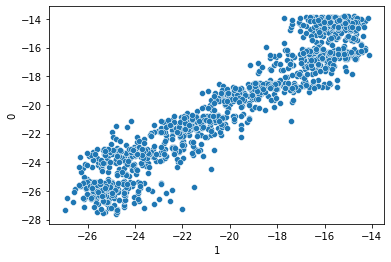

R2 Score: 0.9029890208265523
MSE: 1.5824436696635105
Speramanr: 0.9388332769675534
Cross Validation score: [0.90497425 0.90725613 0.90358733 0.907128   0.91041087]


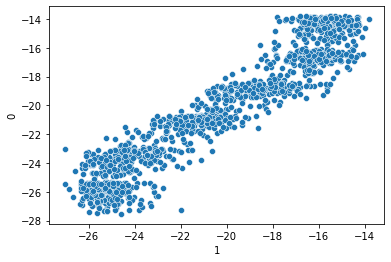

R2 Score: 0.8950645887320833
MSE: 1.6379898686190608
Speramanr: 0.9366625532378842
Cross Validation score: [0.89896872 0.90143292 0.89620423 0.90530466 0.90471316]


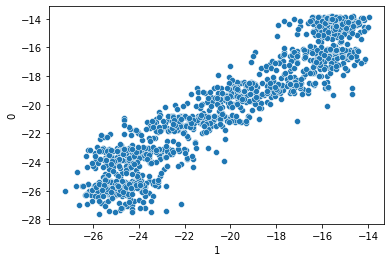

R2 Score: 0.8804656360163373
MSE: 1.824560570410583
Speramanr: 0.9309819918815603
Cross Validation score: [0.88782878 0.87848006 0.86698731 0.88053547 0.87699094]


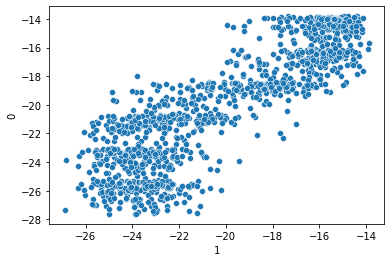

R2 Score: 0.7531748346984859
MSE: 3.957452794958311
Speramanr: 0.8448617186539713
Cross Validation score: [0.77566662 0.73943057 0.76607377 0.76316749 0.75183102]


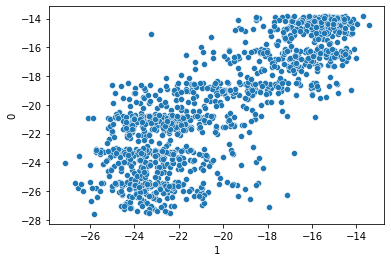

R2 Score: 0.6578675756051541
MSE: 5.405784930971858
Speramanr: 0.7819644388641935
Cross Validation score: [0.66065675 0.68313892 0.66754039 0.64827221 0.63783215]


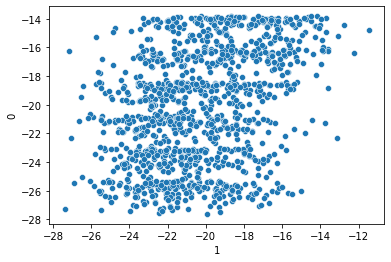

R2 Score: -0.015183994039280169
MSE: 15.730432382140195
Speramanr: 0.33848052950423224
Cross Validation score: [-0.01017038 -0.02869466  0.00443325 -0.01865765 -0.03654497]


<Figure size 432x288 with 0 Axes>

In [75]:
from sklearn.model_selection import train_test_split
X_train_150k, X_test_150k, y_train_150k, y_test_150k = train_test_split(lis_train_150k, logit_(train_target_un_150k), test_size=0.2)


#print(X_train_150k, X_test_150k, y_train_150k, y_test_150k )
model_it(X_train_150k, X_test_150k, y_train_150k, y_test_150k,lis_train_150k, logit_(train_target_un_150k))


X_train_100k, X_test_100k, y_train_100k, y_test_100k = train_test_split(lis_train_100k, logit_(train_target_un_100k), test_size=0.2)
model_it(X_train_100k, X_test_100k, y_train_100k, y_test_100k,lis_train_100k, logit_(train_target_un_100k))

X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(lis_train_50k, logit_(train_target_un_50k), test_size=0.2)
model_it(X_train_50k, X_test_50k, y_train_50k, y_test_50k,lis_train_50k, logit_(train_target_un_50k))

X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(lis_train_10k, logit_(train_target_un_10k), test_size=0.2)
model_it(X_train_10k, X_test_10k, y_train_10k, y_test_10k,lis_train_10k, logit_(train_target_un_10k))

X_train_5k, X_test_5k, y_train_5k, y_test_5k = train_test_split(lis_train_5k, logit_(train_target_un_5k), test_size=0.2)
model_it(X_train_5k, X_test_5k, y_train_5k, y_test_5k,lis_train_5k, logit_(train_target_un_5k))

X_train_1k, X_test_1k, y_train_1k, y_test_1k = train_test_split(lis_train_1k, logit_(train_target_un_1k), test_size=0.2)
model_it(X_train_1k, X_test_1k, y_train_1k, y_test_1k,lis_train_1k, logit_(train_target_un_1k))



In [27]:
def make_shannon(fd):
    from scipy.stats import entropy
    li=[]
    for i in fd: 
        li.append(entropy(i))
    
    return li
        


In [33]:
make_shannon(lis_train_150k)[0],logit_(train_target_un_150k)[0]

(1.5476078005918341, -25.919265654642555)

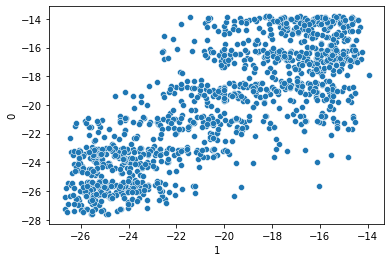

R2 Score: 0.6125885420120111
MSE: 6.197877140680716
Speramanr: 0.7718587821498427
Cross Validation score: [0.90275926 0.91177197 0.90078858 0.90605291 0.9081756 ]


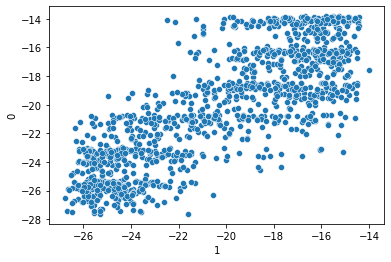

R2 Score: 0.6420558633049763
MSE: 5.602674191633569
Speramanr: 0.7960103015381899
Cross Validation score: [0.90026724 0.89636096 0.89910923 0.90249051 0.89927071]


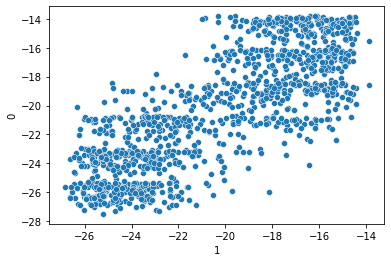

R2 Score: 0.6254167127918935
MSE: 5.843416902269224
Speramanr: 0.7822647081302035
Cross Validation score: [0.87970783 0.88284671 0.87097883 0.87429401 0.88104141]


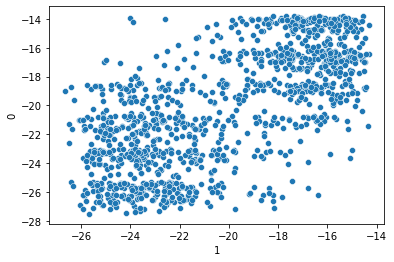

R2 Score: 0.435169146815343
MSE: 8.969814583630077
Speramanr: 0.6678685035271172
Cross Validation score: [0.76093701 0.73776103 0.76257995 0.77378144 0.77068566]


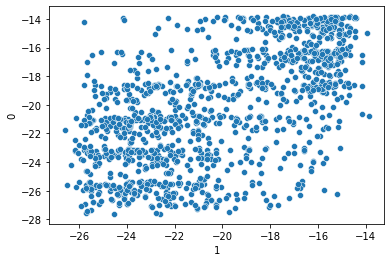

R2 Score: 0.28224867837847556
MSE: 11.054217460416158
Speramanr: 0.5954788825610486
Cross Validation score: [0.66098577 0.65432401 0.64918248 0.64537947 0.63979745]


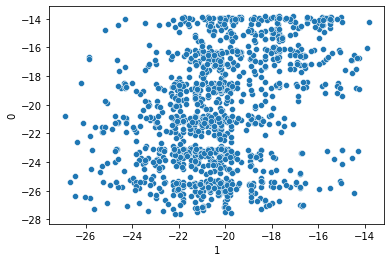

R2 Score: 0.04495821490582008
MSE: 15.212252784411591
Speramanr: 0.32770172257849367
Cross Validation score: [ 0.01171498 -0.03904294  0.01833265  0.03819513 -0.02058531]


<Figure size 432x288 with 0 Axes>

In [31]:
from sklearn.model_selection import train_test_split
X_train_150k, X_test_150k, y_train_150k, y_test_150k = train_test_split(make_shannon(lis_train_150k), logit_(train_target_un_150k), test_size=0.2)


#print(X_train_150k, X_test_150k, y_train_150k, y_test_150k )
model_it(X_train_150k, X_test_150k, y_train_150k, y_test_150k,lis_train_150k, logit_(train_target_un_150k))


X_train_100k, X_test_100k, y_train_100k, y_test_100k = train_test_split(make_shannon(lis_train_100k), logit_(train_target_un_100k), test_size=0.2)
model_it(X_train_100k, X_test_100k, y_train_100k, y_test_100k,lis_train_100k, logit_(train_target_un_100k))

X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(make_shannon(lis_train_50k), logit_(train_target_un_50k), test_size=0.2)
model_it(X_train_50k, X_test_50k, y_train_50k, y_test_50k,lis_train_50k, logit_(train_target_un_50k))

X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(make_shannon(lis_train_10k), logit_(train_target_un_10k), test_size=0.2)
model_it(X_train_10k, X_test_10k, y_train_10k, y_test_10k,lis_train_10k, logit_(train_target_un_10k))

X_train_5k, X_test_5k, y_train_5k, y_test_5k = train_test_split(make_shannon(lis_train_5k), logit_(train_target_un_5k), test_size=0.2)
model_it(X_train_5k, X_test_5k, y_train_5k, y_test_5k,lis_train_5k, logit_(train_target_un_5k))

X_train_1k, X_test_1k, y_train_1k, y_test_1k = train_test_split(make_shannon(lis_train_1k), logit_(train_target_un_1k), test_size=0.2)
model_it(X_train_1k, X_test_1k, y_train_1k, y_test_1k,lis_train_1k, logit_(train_target_un_1k))



In [217]:
result

,0,1
0,7.572274e-07,5.034011e-07
1,1.038645e-08,5.645411e-07
2,5.911595e-07,5.079300e-07
3,6.622205e-08,5.079300e-07
4,1.946211e-07,5.079300e-07
...,...,...
4995,5.260499e-08,4.943433e-07
4996,9.549007e-07,5.011366e-07
4997,6.390912e-07,4.966077e-07
4998,8.215337e-07,5.124589e-07


In [149]:
from scipy.stats import spearmanr
rho, p = spearmanr(pred_df,true_df)


In [150]:
rho

0.0013696758937499045

In [65]:
p

0.9228641461332141

In [218]:
infoFilename= os.path.join('./train',"train_rate.npy")
param =np.load(infoFilename)

In [219]:
param

array([4.23278173e-07, 5.21599833e-08, 5.04315826e-09, ...,
       8.09484784e-07, 1.21381116e-07, 8.17029978e-07])

In [220]:
max(param)

9.999504971394293e-07

In [221]:
list(param).index(max(param))

11985

In [222]:
min(param)

5.0654946706451514e-11

In [223]:
list(param).index(min(param))

6468

In [72]:
infoFilename= os.path.join('./train_150',"train_150.npy")
param =np.load(infoFilename)

FileNotFoundError: [Errno 2] No such file or directory: './train_150/train_150.npy'

In [225]:
param

array([7.57227363e-07, 1.03864452e-08, 5.91159487e-07, ...,
       6.39091220e-07, 8.21533728e-07, 2.97590084e-07])

In [226]:
max(param)

9.998256885367724e-07

In [227]:
list(param).index(max(param))

1273

In [228]:
min(param)

6.111681250110419e-11

In [229]:
list(param).index(min(param))

1297